# Midterm Project

Improve the music transcription result from Lab 5 (maximum likelihood estimation) using a hidden Markov model and the Viterbi algorithm. 

## Rubric
1. Your program runs without syntax or runtime errors after I click "Restart & Run All" on Jupyter notebook.
2. The two lines of code in Step 1 and Step 3 are correct.
3. The generated figure in Step 2 includes all the required elements (a title, x and y-labels, and a legend).
4. Your implementation in Step 4 uses the Viterbi algorithm and generates the correct result.
5. Your implementation in Step 4 has straightforward logic and good variable names (descriptive and accurate).

Please submit both the Notebook file (.ipynb) and the Python file (.py).

## Step 1: Build the Markov chain
We build on the Markov chain described in Lab 6, with slight modification. Besides the five states for each midi notes, we add a "silence note", allowing the model to represent silence in the music recording. As a result, the first five rows (Row 0-4) in the transition matrix represent the "silence note", and Row 5-9 represent the `LOW_MIDI`. **Your task:** Understand every line of code, and then complete Line 8.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define states
LOW_MIDI = 47
HIGH_MIDI = 74
STATES_PER_NOTE = 5
STATE_VALUES = ((HIGH_MIDI - LOW_MIDI) + 2) * STATES_PER_NOTE # REPLACE IT WITH THE TOTAL NUMBER OF POSSIBLE STATES (INCLUDING "SILENCE")

# Define initial distribution
init_dist = np.zeros(STATE_VALUES)
for i in range(STATE_VALUES):
    if i % STATES_PER_NOTE  == 0: # equal chance of being in the first state of any note
        init_dist[i] = 1/STATE_VALUES

# Define transition matrix
A = np.zeros((STATE_VALUES, STATE_VALUES))
for i in range(A.shape[0]): # for each state
    A[i, i] = 1 # every state has a self loop
    if (i+1)%STATES_PER_NOTE  != 0: # if this state is not the fifth state of a note
        A[i, i+1] = 1 # this state has an arrow to the next state (which is within the same note)
    else: # if this state is the fifth state of a note
        for j in range(STATE_VALUES // STATES_PER_NOTE):
            A[i, j*STATES_PER_NOTE ] = 1

# Normalize every row so each row sums to 1
for i in range(A.shape[0]):
    A[i, ] = A[i, ] / sum(A[i, ])

## Step 2: Create templates
The functions below help create templated for each note. Don't change these functions. **Your task:** Plot at least two templates in the same figure, with different colors. Be sure to add a title, x and y-labels, and a legend (indicating which midi is which color). You may call `create_midi_templates(1024, 8000)` to get all the templates, including the one for "silence".

In [4]:
import math

def peak_fun(x):
    """
    Constructs and returns a harmonic peak
    """
    return math.exp(-0.5*x*x)


def midi2freq(midi):
    """
    Returns the frequency (in Hz) of the given midi number
    """
    return 440*np.power(2, (midi-69)/12)


def template(midi, N, sr):
    """
    Returns a frequency profile template for the given midi note.
        midi: midi number
        N: frame size (must be an even number)
        sr: sample rate
    """
    if N % 2 != 0:
        print("Frame size is not even!")
        return None
    f0 = midi2freq(midi) # fundamental frequency
    H = 13 # maximumn number of harmonics to include
    bins = math.floor(N/2) # half of the DFT result
    template = np.zeros(bins) 
    
    for h in range(1, H+1): # h = 1, 2, 3, ..., H
        bin = round(f0*h*N/sr) # bin index of this harmonic
        if bin >= bins: # exceeds Nyquist frequency
            break
        sigma = bin * 0.01 + 0.01 # controls the width of the peak
        for k in range(bins):
            x = (k-bin)/sigma
            template[k] += math.exp(-k*0.01) * peak_fun(x) # descreasing amplitudes for higher frequencies
    
    for k in range(bins):
        template[k] += 0.002
    # Normalize all bins:
    total = sum(template)
    if (total > 0):
        template = template / total
    else:
        print("The template has 0 everywhere!")
    return template


def create_midi_templates(N, sr):
    """
    Returns a dictionary where the key is a midi number (or 0) and
    the value is the template of this midi note.
    (silence is represented by 0)
    """
    templates = {}
    for midi in range(LOW_MIDI, HIGH_MIDI + 1):
        templates[midi] = template(midi, N, sr)
    # Template for "silence":
    templates[0] = np.repeat(1/math.floor(N/2), math.floor(N/2)) # flat template
    return templates

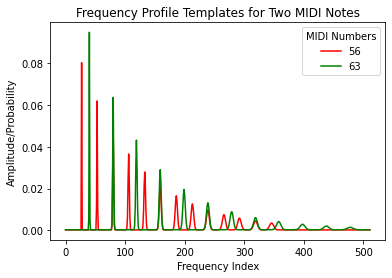

array([0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00034745, 0.0803367 , 0.00034473, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020994, 0.00027612, 0.01144379, 0.0619918 , 0.01122134,
       0.00027353, 0.00020994, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020993,
       0.00020993, 0.00020993, 0.00020993, 0.00020993, 0.00020

In [7]:
## YOUR CODE HERE...
created_templates = create_midi_templates(1024, 8000)
plt.plot(created_templates[56], color="red")
plt.plot(created_templates[63], color="green")
plt.legend(('56','63'), loc = 'upper right', title = 'MIDI Numbers')
plt.xlabel("Frequency Index")
plt.ylabel("Amplitude/Probability")
plt.title("Frequency Profile Templates for Two MIDI Notes")
plt.show()
created_templates[56]

## Step 3: Calculate likelihoods given audio
This code below calculates the likelihoods for each frame in the audio, and for each note (NOT state). The calculated `likelihoods` in the end will be used to get emission probabilities in Step 4, where states associated with the same note will share the same emission probability. **Your task:** Read and understand every line of code, and then complete Line 39.

In [6]:
import librosa
from numpy.fft import fft


def calculate_likelihood(tmplt, spectrum):
    """
    Calculates and returns the likelihood of observing the spectrum given the template.
        T: the spectral template
        spectrum: the observed spectrum of a frame
        (T and spectrum must have the same length.)
    """
    if np.sum(spectrum) == 0:
        print("In calculate_likelihood: sum of spectrum is 0!")
    else:
        spectrum = spectrum / np.sum(spectrum) # normalize the signal (ignore volumn)
    if (len(tmplt) != len(spectrum)):
        print("The length of the spectrum and the template doesn't match!")
        return None
    log_like = 0
    for k in range(len(tmplt)):
        log_like += (spectrum[k]*math.log(tmplt[k]))
    return math.exp(log_like) # log likelihood -> likelihood


def calculate_all_likelihoods(templates, spectrogram):
    """
    Calculates and returns all the likelihoods of observing each frame in the spectogram
    given each template. The returned value is a two-dimensional array. The row indice represent
    midi numbers, and column indices are the frame indices. Note that Row 1 ~ Row (LOW_MIDI-1)
    are all zeros because they are not considered in our program.
        templates: a dictionary containing the spectral templates of all possible notes (including silence)
        spectrogram: the observed spectrogram including all frames (dimension: bins rows * frames columns)
        (The length of the templates must be the same as the numbers of rows in spectrogram.)
    """
    T = spectrogram.shape[1] # the total number of frames
    likelihoods = np.zeros((HIGH_MIDI+1, T))
    for t in range(T):
        spectrum = spectrogram[:, t]
        likelihoods[0, t] = calculate_likelihood(templates[0], spectrum) # REPLACE 0 WITH THE REAL LIKELIHOOD FOR THE SILENCE NOTE
        for midi in range(LOW_MIDI, HIGH_MIDI + 1):
            likelihoods[midi, t] = calculate_likelihood(templates[midi], spectrum)
    return likelihoods


SR = 8000 # DON'T CHANGE
N = 1024 # DON'T CHANGE
hop = int(N/2) # DON'T CHANGE
file_path = "bass_oboe.wav"
samples, sr = librosa.load(file_path, sr = SR)

# Calculate STFT
T = math.floor( (len(samples)-N) / hop ) + 1 # the total number of frames
STFT = np.zeros((N, T), dtype='complex') # the STFT result is a N by T matrix
hann = 0.5 * ( 1 - np.cos(2*np.pi*np.arange(N)/N) ) # Hann window
for t in range(T): # for each frame
    chunck = samples[t*hop : t*hop + N] # get the frame t of audio data
    X = fft(chunck * hann) # apply FFT on windowed signal (the result contains N complex numbers)
    STFT[:, t] = X
spect = np.abs(STFT[:int(N/2), :]) # complex numbers --> abs values

# Calculate likelihoods for each midi (NOT state) at each frame (row 0 represents silence)
midi_templates = create_midi_templates(N, sr)
likelihoods = calculate_all_likelihoods(midi_templates, spect)

/usr/local/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: 'bass_oboe.wav'

## Step 4: Inference
**Your task:** Implement the Viterbi algorithm to find the most likely state sequence. I recommend understanding the examples from Week 7 Monday before doing this step.

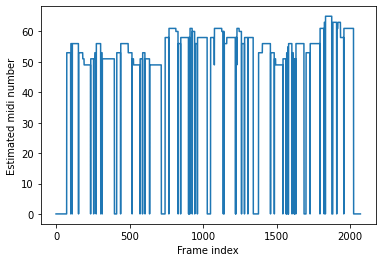

In [ ]:
# YOUR CODE HERE...
    
## For each frame, find the midi with the largest likelihood
notes = np.zeros(T)
for t in range(T):
    likelihoods_per_frame = likelihoods[:, t]
    largest_likelihood = -float("inf") # smallest float number
    for midi in range(LOW_MIDI, HIGH_MIDI + 1): # Doesn't include 'silence' here
        if likelihoods_per_frame[midi] > largest_likelihood:
            largest_likelihood = likelihoods_per_frame[midi]
            notes[t] = midi
    if likelihoods_per_frame[0] > largest_likelihood:
        notes[t] = 0
        
# print(notes)
plt.plot(notes)
plt.xlabel('Frame index')
plt.ylabel('Estimated midi number')
plt.show()

# result = a numpy array that stores the most likely state sequence

In [ ]:
e = np.zeros((STATE_VALUES,T))

for row in range(5):
    e[row, ] = likelihoods[0, ]
    
index = 5

for row in range(LOW_MIDI, HIGH_MIDI + 1):
    for increment in range(5):
        e[index, ] = likelihoods[row, ]
        index += 1

In [ ]:
e = np.zeros((STATE_VALUES,T))

for row in range(5):
    e[row, ] = likelihoods[0, ]
    
index = 5

for row in range(LOW_MIDI, HIGH_MIDI + 1):
    for increment in range(5):
        e[index, ] = likelihoods[row, ]
        index += 1

optimal_score = np.zeros((STATE_VALUES, T)) # optimal_score[s, t] is the best score through the latice
                                            # to state s at time t
optimal_pred = np.zeros((STATE_VALUES, T), dtype=int) # optimal_pred[s, t] is the optimal predecessor state
                                                      # of state s at time t. So optimal_pred[s, t] represents
                                                      # a state value at time t-1
for s in range(STATE_VALUES):
    optimal_score[s, 0] = init_dist[s] * e[s, int(notes[0])] #optimal score for very first instance
for t in range(1, T): # for each time stamp
    for s in range(STATE_VALUES): # for each state at time t, for each state
        for p in range(STATE_VALUES): # for each predecessor state at time t-1, when in each state need to look at predecessor which is also two states
            score = optimal_score[p, t-1] * A[p, s] * e[s, t] # calculate the score if we come to s from p
            if score > optimal_score[s, t]:
                optimal_score[s, t] = score
                optimal_pred[s, t] = p
    optimal_score[:, t] /= sum(optimal_score[:, t]) # rescale to avoid underflow


result = np.zeros(T, dtype=int) # stores the inference result
print('Optimal Score', optimal_score)
result[T-1] = np.argmax(optimal_score[:, T-1]) # choose the best final state
# Follow pointers back through trellis:
for t in range(T-2, -1, -1): # t = 98, 97, ..., 1, 0
    result[t] = optimal_pred[result[t+1], t+1]
    print(result[t])
print(result)
print("\nInference result:\n", A[result, ])


Optimal Score [[1.34698276e-05 2.02947131e-01 2.50443073e-01 ... 1.81718350e-01
  1.82351770e-01 1.82517379e-01]
 [0.00000000e+00 2.02947131e-01 2.50443073e-01 ... 1.81718350e-01
  1.82351770e-01 1.82517379e-01]
 [0.00000000e+00 0.00000000e+00 2.50443073e-01 ... 1.81718350e-01
  1.82351770e-01 1.82517379e-01]
 ...
 [0.00000000e+00 0.00000000e+00 7.20350964e-03 ... 3.54311236e-04
  3.39279624e-04 3.14631526e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.96145906e-05
  1.06090155e-04 9.88369064e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.92972194e-05
  2.98272430e-05 3.09055479e-05]]
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
79
78
77
76
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
75
64
63
62
61
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
89
88
87
86
85
85
85
85
85


## Step 5: Show recognition result
The code below visualizes the recognition result from Step 4, and synthesizes a performance based on your result. There are no tasks for you in this step other than using the code to examine your result. An example result will be posted on Slack.

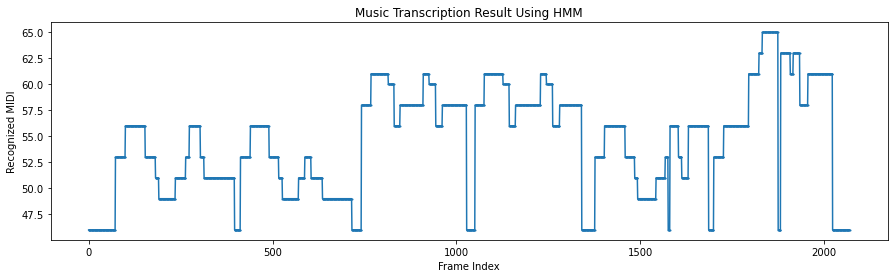

In [ ]:
import matplotlib.pyplot as plt

notes = (result // STATES_PER_NOTE ).astype(float)
# notes[notes==0] = np.nan # set every 0 to be nan to avoid plotting silence (midi=0)
recognized_midi = LOW_MIDI - 1 + notes
plt.figure(figsize=(15, 4))
plt.plot(recognized_midi, marker = 'o', markersize=1)
plt.ylabel("Recognized MIDI")
plt.xlabel("Frame Index")
plt.title("Music Transcription Result Using HMM")
plt.show()

In [ ]:
import IPython.display as ipd

# Synthesize a performance based on the transcription result.
# You should hear almost the same music.

sr = 8000 # sampling rate
note_duration = hop/sr # duration of each frame
wav = np.array([])
freq = np.array([])
for midi in recognized_midi:
    if np.isnan(midi):
        f = 0
    else:
        f = midi2freq(midi)
    freq = np.append(freq, np.repeat(f, sr*note_duration)) # the frequency value for every sampled time
wav = np.sin(2*np.pi*np.cumsum(freq/sr)) # cumulative sum is like doing integration (refer back to Lab 3)

ipd.Audio(wav, rate=sr)